
Objective of the notebook is to explore the data, to build and compare baseline models.

**Objective of the competition:**

The objective is to predict which Tweets are about real disasters and which ones are not
Predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.



# NLP:
* EDA (with WordCloud) 
* Bag of Words 
* TF IDF
* SVM, RF, using TFIDF
* Neural Network Using TFIDF
* Recurrent Neural Network
* Recurrent Network With Glove Embedding


In [1]:
import string
import re
from os import listdir
from numpy import array
from nltk.corpus import stopwords
from collections import Counter
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_colwidth', -1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score,roc_curve
import numpy as np
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from keras.preprocessing.sequence import pad_sequences

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dense, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

print("Libraries loaded")

Using TensorFlow backend.


Libraries loaded


**Read the data**

In [2]:
path = '../input/nlp-getting-started/'
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")


In [3]:
train['actual_text'] = train['text']

In [4]:
test.isnull().sum()

id          0   
keyword     26  
location    1105
text        0   
dtype: int64

**Not Disaster tweets**

In [5]:
train[train.target==0]['text']

15      What's up man?                                                                                                                 
16      I love fruits                                                                                                                  
17      Summer is lovely                                                                                                               
18      My car is so fast                                                                                                              
19      What a goooooooaaaaaal!!!!!!                                                                                                   
                    ...                                                                                                                
7581    @engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO                       
7582    Cramer: Iger's 3 words that wrecked Disn

**Disaster tweets**

In [6]:
train[train.target==1]['text']

0       Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                    
1       Forest fire near La Ronge Sask. Canada                                                                                                   
2       All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected    
3       13,000 people receive #wildfires evacuation orders in California                                                                         
4       Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school                                                  
                                                  ...                                                                                            
7608    Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5                                 

In [7]:
# train = train.head(10)?
test_df = test

**Target Distribution:**

First let us look at the distribution of the target variable to understand more about the imbalance and so on.

In [8]:
train["target"].value_counts() / len(train) *100

0    57.034021
1    42.965979
Name: target, dtype: float64

About 42 % of the data is about real disasters

Text(0, 0.5, 'count')

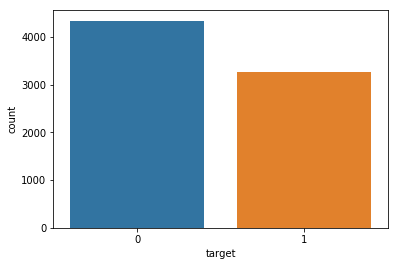

In [9]:
import seaborn as sns
ax = sns.countplot(x='target', data=train)
ax.set_xlabel('target')
ax.set_ylabel("count")  

**Word Cloud:**

Now let us look at the frequently occuring words in the data by creating a word cloud on the 'text' column.

**1) Word cloud of Not disaster tweet**

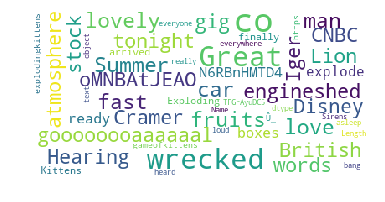

In [10]:
stopwords = set(STOPWORDS)


wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[train.target==0]['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

**2) Word cloud of Real Disaster Tweet**

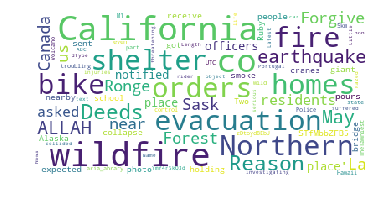

In [11]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[train.target==1]['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=300)

In [12]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of Non Diaster Tweets", 
                                          "Frequent words of real Diaster Tweets"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()


/opt/conda/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Observations:**
* Some of the top words are common across both the classes like 'people', emergency, building

Now let us also create bigram frequency plots for both the classes separately to get more idea.

In [13]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Non Diaster Tweets", 
                                          "Frequent bigrams of real Diaster Tweets"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')


**Meta Features:**

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [14]:
## Number of words in the text ##
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



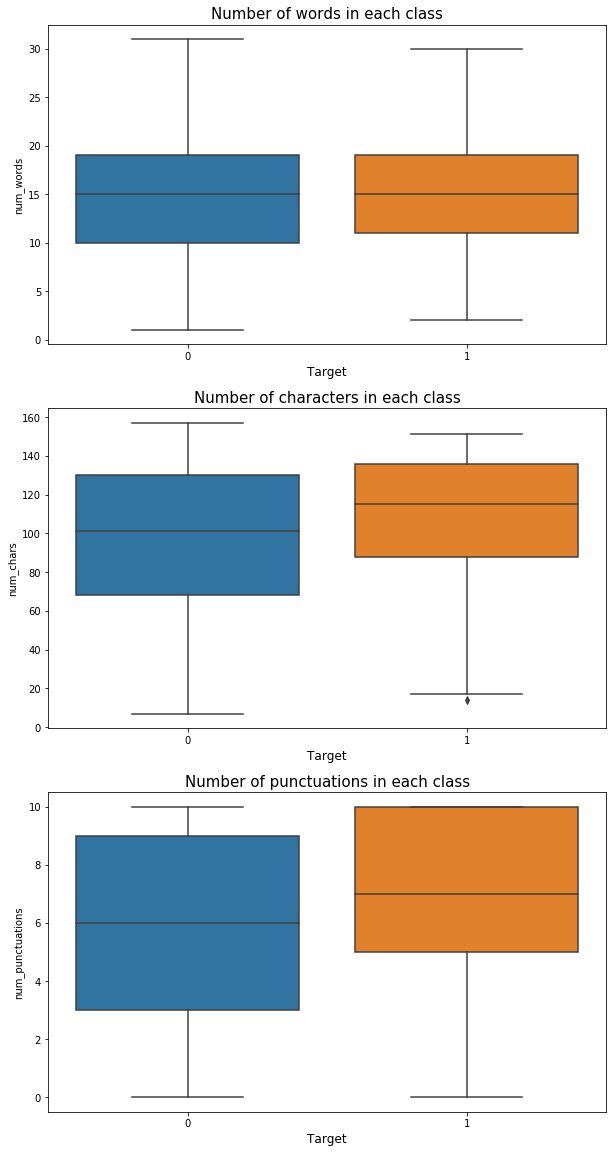

In [15]:
## Truncate some extreme values for better visuals ##
train['num_words'].loc[train['num_words']>60] = 60 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>10] = 10 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()


**Inference:**
* We can see that the tweets of both classes has more or less same words

**Text Preprocessing:**
* Lower casing
* Removal of Punctuations
* Removal of Stopwords
* Stemming
* Removal of URLs
* Removal of HTML tags

In [16]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


train['text']=train['text'].apply(lambda x : remove_URL(x))
train['text']=train['text'].apply(lambda x : remove_html(x))
train['text']=train['text'].apply(lambda x : remove_punct(x))


test_df['text']=test_df['text'].apply(lambda x : remove_URL(x))
test_df['text']=test_df['text'].apply(lambda x : remove_html(x))
test_df['text']=test_df['text'].apply(lambda x : remove_punct(x))

train['text']=train['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
test_df['text']=test_df['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))


import warnings; warnings.simplefilter('ignore')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop = stopwords.words('english')

train['text'] = train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# train['text'] = train['text'].str.replace('\d+', '')
test_df['text'] = test_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# test_df['text'] = test_df['text'].str.replace('\d+', '')



stemmer = SnowballStemmer('english')
train['text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
test_df['text'] = test_df['text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [17]:
## split to train and val
train_df, val_df = train_test_split(train, test_size=0.1, random_state=2018)


** Code for Confusion matrix**

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,roc_auc_score,roc_curve, auc,  f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
# Making the Confusion Matrix
def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print(" True positive rate or (Recall or Sensitivity) :",metrics.recall_score(y_test, y_pred))

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)

    #Specitivity. or True negative rate
    print(" True Negative rate or Specitivity :",specificity)

    false_negative = fn / (fn+tp)

    #False negative rate
    print(" False Negative rate :",false_negative)

    #False positive rate
    print(" False positive rate (Type 1 error) :",1 - specificity)
    
    print('F Score', f1_score(y_test, y_pred))
    print(cm)



To start with, let us just build a baseline model (Logistic Regression) with TFIDF vectors.

** TF IDF **

In [19]:
# ## some config values 
# Get the tfidf vectors #
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV


train_X = train_df["text"].fillna("_na_")
val_X = val_df["text"].fillna("_na_")
test_X = test_df["text"].fillna("_na_")

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_vec.fit_transform(train_X.values.tolist()+val_X.values.tolist())
train_tfidf = tfidf_vec.transform(train_X.values.tolist())
val_tfidf = tfidf_vec.transform(val_X.values.tolist())
test_tfidf = tfidf_vec.transform(test_X.values.tolist())
print("tfidf done")




tfidf done


** Build a DummyClassifier which works on basic rules **

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
Accuracy: 0.568241469816273
Precision: 0.0
 True positive rate or (Recall or Sensitivity) : 0.0
 True Negative rate or Specitivity : 1.0
 False Negative rate : 1.0
 False positive rate (Type 1 error) : 0.0
F Score 0.0
[[433   0]
 [329   0]]


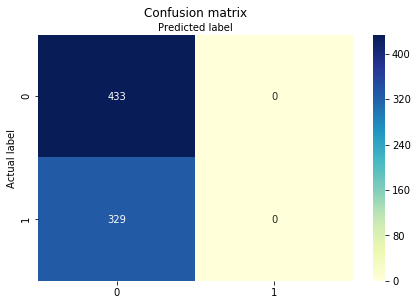

In [20]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
print(dummy_clf)
dummy_clf.fit(train_tfidf, train_y)

y_dummy_clf = dummy_clf.predict(val_tfidf)

get_metrics(val_y, y_dummy_clf)


** Now, Lets try out a Random Forest Classifier**

Accuracy: 0.5931758530183727
Precision: 1.0
 True positive rate or (Recall or Sensitivity) : 0.057750759878419454
 True Negative rate or Specitivity : 1.0
 False Negative rate : 0.9422492401215805
 False positive rate (Type 1 error) : 0.0
F Score 0.10919540229885057
[[433   0]
 [310  19]]


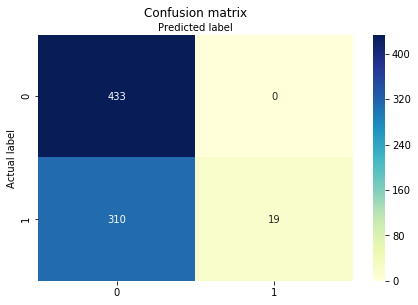

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier( n_estimators=100, max_depth=5,    
                            min_samples_leaf=10, min_samples_split=20,
                            random_state=10)
grid_param = {
    'max_depth': [4,5],
    'min_samples_leaf': [10,20]
}

gd_sr = GridSearchCV(estimator=rf,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=3,
                     n_jobs=-1)

gd_sr.fit(train_tfidf, train_y)

y_pred_rf = gd_sr.predict(val_tfidf)


get_metrics(val_y, y_pred_rf)


We can see that the Accuracy is not good with the Random Forest.

** Lets try out Logistic Regression **

Accuracy: 0.8202099737532809
Precision: 0.872093023255814
 True positive rate or (Recall or Sensitivity) : 0.6838905775075987
 True Negative rate or Specitivity : 0.9237875288683602
 False Negative rate : 0.3161094224924012
 False positive rate (Type 1 error) : 0.07621247113163976
F Score 0.7666098807495741
[[400  33]
 [104 225]]


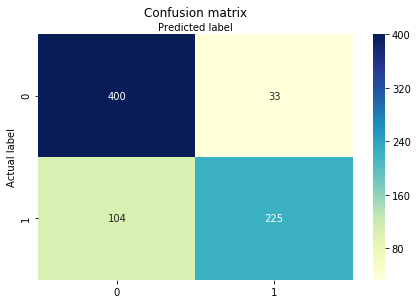

In [22]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()


classifier.fit(train_tfidf, train_y)

y_pred_val_lr = classifier.predict(val_tfidf)

get_metrics(val_y, y_pred_val_lr)



Now let us look at the important words used for classifying the real vs not real disaster tweets


In [23]:
import eli5
eli5.show_weights(classifier, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+3.583,hiroshima
+3.114,california
+3.072,fires
+2.877,train
+2.702,killed
+2.621,earthquake
+2.507,suicide
+2.470,wildfire
+2.457,buildings
+2.279,bombing


** SVM **

In [24]:
# from sklearn import svm

# model = svm.SVC(kernel='linear', probability=True)
# grid_param = {
#     'C': [1],
#     'gamma': [0.001]
# }

# gd_sr = GridSearchCV(estimator=model,
#                      param_grid=grid_param,
#                      scoring='accuracy',
#                      cv=3,
#                      n_jobs=-1)

# gd_sr.fit(train_tfidf, train_y)

# y_pred_val_svm = gd_sr.predict(val_tfidf)

# get_metrics(val_y, y_pred_val_svm)
# print(gd_sr.best_params_)

Lets check some tweets that are misclassified

In [25]:
temp = val_df
temp.reset_index(drop=True, inplace=True)
forReview =pd.concat([temp, pd.DataFrame(y_pred_val_lr)],axis=1,ignore_index=True)
forReview= forReview.iloc[:,[3,4,5,14]]
forReview.columns = ['text','target','actual_text','predicted']
forReview

,text,target,actual_text,predicted
0,get å£150 free bets register boylesports casino luck destroy,0,Get å£150 free bets when you register at Boylesports Casino #Luck #Destroy http://t.co/zildpvKNXP http://t.co/5yDb4s13pF,0
1,jamesjustus returns relax know always return need panic gave corn flakes p,0,@james_justus *returns her*\n\nRelax. You know I always return her so no need to panic. I just gave her some of those corn flakes. :P,0
2,imagine school suicide bombing taught teachers would say students please pay,1,Imagine a school where suicide bombing Is being taught the teachers would say to the students...\n\n'Please pay... http://t.co/zfiVVxYDZY,1
3,virgin galactic crash early unlocking brakes triggered structural failure crash virgin galactic,1,Virgin galactic crash: early unlocking of brakes triggered structural failure: The crash of a Virgin Galactic ... http://t.co/x3VqxdouVT,1
4,sometimesi cant even breathe well feel like drowning cant deal fear anxietyproblems,0,SometimesI can't even breathe well\nI feel like drowning and can't deal with my fear\n#anxietyproblems,0
...,...,...,...,...
757,08062015 alabamaquake seismic summary w earthquake news amp history,1,The 08/06/2015 AlabamaQuake seismic summary w/ #earthquake #news &amp; history http://t.co/zM6VcZqvWk http://t.co/DKNlZNom6n,1
758,samelsamel crush,0,samel_samel has a crush: http://t.co/tBsTk5VqU0,0
759,news science london warship exploded 1665 sailors recycling artillery cartridges life tech,1,#news #science London warship exploded in 1665 because sailors were recycling artillery cartridges... http://t.co/r4WGXrA59M #life #tech,0
760,friday palm beach county grindhouse series one night screening texaschainsawmassacre morbidmovies,0,This Friday!! Palm Beach County #Grindhouse Series one night screening of #TexasChainsawMassacre http://t.co/1WopsGbVvv @morbidmovies,0


Tweets that got misclassified as Disaster tweets

In [26]:
forReview[(forReview['target']==0) & (forReview['predicted']==1)]

,text,target,actual_text,predicted
64,mfalcon21 go look blew w atomic bomb,0,@mfalcon21 go look. Just blew it up w atomic bomb.,1
101,today fell rock scraped whole butt nearly drowned summer2k15,0,So today I fell off a rock scraped my whole butt and nearly drowned #summer2k15,1
103,captain abbott must go lnp boat refugees christianvalues,0,Captain Abbott must go down with LNP boat #refugees #christianvalues https://t.co/Kp5dpOaF58,1
130,defendbutera look like mass murderer,0,@defendbutera i look like a mass murderer in it,1
134,mourning notices stabbing arson victims stir û÷politics griefûª israel posters shira banki,0,Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe,1
161,team ready natural disaster violent client power outage contact ready vet design,0,Is your team ready for a natural disaster a violent client or power outage? Contact Ready Vet to design... http://t.co/u2NJPoR39K,1
173,wwi wwii japanese army navy military japan leather watch war mido ww1 2 full read ebay,0,WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/QUmcE7W2tY http://t.co/KTKG2sDhHl,1
179,cartoon bears without would qave knowlddge forest fires toilet paper,0,Cartoon Bears. Without them we would qave no knowlddge of forest fires or toilet paper.,1
186,fire hazard associated installation noncompliant external cladding highrise buildings insurance aust,0,Fire hazard associated with installation of non-compliant external cladding on high-rise buildings - Insurance - Aust http://t.co/wFsEaOBATo,1
208,victoriagittins take im mass murderer one,0,@VictoriaGittins what do you take me for I'm not a mass murderer! Just the one...,1


Disaster Tweets that got misclassified as Not Disaster tweets

In [27]:
forReview[(forReview['target']==1) & (forReview['predicted']==0)]

,text,target,actual_text,predicted
19,evacide ferguson riots worked next time say rioting doesnt change anything fixed,1,@evacide The Ferguson RIOTS worked. This of this the next time you say RIOTING doesn't change anything.\n\nThere fixed it for you.,0
24,meetkakarotto dont bother offline managed evacuate everyone including hinata go ahead cause,1,@MeetKakarotto 'Don't bother while you were offline I managed to evacuate everyone out of here including Hinata so so go ahead and cause--,0
26,another movie theater attackclose home time thankful casualties life go cannot allow evil win,1,Another movie theater attack..close to home this time. Thankful for no casualties. Life will go on because we cannot allow evil to win!,0
33,wtf mom drowned child,1,Wtf this mom just drowned her child?!,0
34,prophet peace upon said save hellfire even giving half date charity,1,The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',0
...,...,...,...,...
738,thunder shook house woke sister made car alarms go,1,The thunder shook my house woke my sister and made car alarms go off ????,0
742,new post darkreading new smb relay attack steals user credentials internet,1,New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet,0
745,tomcatarts thus explaining annihilated case survivor evolved became godlike,1,@TomcatArts thus explaining why you were all annihilated. But the few or in this case you the only survivor evolved and became godlike,0
746,pandemonium aba woman delivers baby without face photos,1,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos).... http://t.co/lYXNjlxL8s http://t.co/CXYFqN3ue4,0


**Neural Network**

In [28]:
# # define the model
# model = Sequential()
# model.add(Dense(1024, input_dim=train_tfidf.shape[1]))
# model.add(Activation('relu'))

# model.add(Dense(1024))
# model.add(Activation('relu'))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(model.summary())
# es = EarlyStopping(monitor='val_loss', patience=5)
# model.fit(train_tfidf,train_y, batch_size=512, epochs=1, validation_data=(val_tfidf, val_y), callbacks=[es])

# val_pred_y = model.predict_classes([val_tfidf], batch_size=1024, verbose=1)
# # val_pred_y = (val_pred_y>0.5).astype(int)
# get_metrics(val_y,val_pred_y)


** Recurrent Neural Network **

In [29]:

# ## some config values 
# embed_size = 300 # how big is each word vector
# max_features = 5000 # how many unique words to use (i.e num rows in embedding vector)
# maxlen = 100 # max number of words in a question to use

# ## fill up the missing values
# train_X = train_df["text"].fillna("_na_").values
# val_X = val_df["text"].fillna("_na_").values
# test_X = test_df["text"].fillna("_na_").values

# ## Tokenize the sentences
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(train_X))
# train_X = tokenizer.texts_to_sequences(train_X)
# val_X = tokenizer.texts_to_sequences(val_X)
# test_X = tokenizer.texts_to_sequences(test_X)

# ## Pad the sentences 
# train_X = pad_sequences(train_X, maxlen=maxlen)
# val_X = pad_sequences(val_X, maxlen=maxlen)
# test_X = pad_sequences(test_X, maxlen=maxlen)

# ## Get the target values
# train_y = train_df['target'].values
# val_y = val_df['target'].values


**Without Pretrained Embeddings:**


In [30]:
# embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# model.add(Dense(1024))
# model.add(Activation('relu'))
# model.add(Dropout(.2))

# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# es = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y), callbacks=[es])

# val_pred_y = model.predict_classes([val_X], batch_size=1024, verbose=1)
# get_metrics(val_y,val_pred_y)


**Now try with Glove embedding Embedding**

In [31]:
# import numpy as np
# EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'
# def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

# all_embs = np.stack(embeddings_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index)) + 1
# embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

In [32]:

# # define the model
# model = Sequential()

# e = Embedding(len(embedding_matrix), embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)
# model.add(e)
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # summarize the model
# print(model.summary())
# es = EarlyStopping(monitor='val_loss', patience=10)
# model.fit(train_X, train_y, batch_size=512, epochs=10, validation_data=(val_X, val_y), callbacks=[es])

# val_pred_y = model.predict_classes([val_X], batch_size=1024, verbose=1)
# get_metrics(val_y,val_pred_y)

# # pred_glove_embed_y = model.predict([test_X], batch_size=1024, verbose=1)

BERT

In [33]:
# !pip install tokenizers

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [35]:
path = '../input/nlp-getting-started/'
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

train = train[:2000]
## split to train and val
# train_df, val_df = train_test_split(train, test_size=0.2, random_state=2018)

In [36]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [37]:
tokenized = train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Padding

In [38]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [39]:
np.array(padded).shape

(2000, 82)

Masking

In [40]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 82)

In [41]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [42]:
last_hidden_states

(tensor([[[-0.0078,  0.2434, -0.1924,  ..., -0.0423,  0.5865,  0.0078],
          [ 0.3320,  0.3346,  0.0207,  ..., -0.1569,  0.8014, -0.4104],
          [ 0.5480,  0.2635,  0.1367,  ...,  0.0184,  0.0848, -0.2652],
          ...,
          [ 0.0152,  0.2166,  0.1225,  ...,  0.1965,  0.0519, -0.1487],
          [-0.0369,  0.2852,  0.1945,  ...,  0.0811,  0.0711, -0.1032],
          [ 0.0386,  0.2874,  0.1401,  ...,  0.0651,  0.1448, -0.0140]],
 
         [[-0.5075,  0.1034, -0.6453,  ..., -0.2546,  0.2126,  0.3391],
          [ 0.4142,  0.5571, -0.3625,  ..., -0.0183,  0.3380, -0.0851],
          [ 0.3048,  0.2969, -0.3315,  ..., -0.3804, -0.0696, -0.3818],
          ...,
          [-0.1041,  0.1329, -0.2229,  ..., -0.0524, -0.0426,  0.2601],
          [-0.0437,  0.0847, -0.2386,  ...,  0.0112, -0.1759,  0.4035],
          [ 0.0222,  0.1052, -0.3387,  ...,  0.0053, -0.2005,  0.2808]],
 
         [[-0.1455, -0.1657,  0.2994,  ..., -0.1828,  0.0257,  0.4130],
          [-0.1536,  0.0443,

In [43]:
features = last_hidden_states[0][:,0,:].numpy()
labels = train.target
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [44]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.832